In [55]:
!ls ../data/kustosija

attacking_set_pieces.csv     passing.csv
attacking_shot_on_goal.csv   positive_transition.csv
counterpress.csv             positive_transition_peak.csv
deffending_set_pieces.csv    possesion.csv
deffending_shot_on_goal.csv  possesion_peak.csv
dribling.csv                 pressing.csv
error.csv                    pressing_peak.csv
interception.csv             second_ball.csv
negative_transition.csv      stats
negative_transition_peak.csv substitution.csv


In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tagging import helpers, data

In [292]:
dataset = "zmijavci" # "kustosija"
path = f"../data/{dataset}"

In [293]:
def preprocess_data_for_timeline(path, name):
    df = data.preprocess_data(path, f"{name}.csv")
    df["minute"] = df["time_seconds"] / 60
    df = df.set_index("minute")
    df.index = pd.TimedeltaIndex(df.index, unit="min")
    df = df.rename(columns={"duration_seconds": f"duration_{name}"})

    return df

In [294]:
def add_game_start_entry(df, columns):
    df_game_start = pd.DataFrame({c: 0 for c in columns}, index=pd.TimedeltaIndex([0], unit="min"))
    return pd.concat([df_game_start, df])

In [295]:
df_possession = preprocess_data_for_timeline(path, "possesion")
df_pressing = preprocess_data_for_timeline(path, "pressing")
df_pos_transition = preprocess_data_for_timeline(path, "positive_transition")
df_neg_transition = preprocess_data_for_timeline(path, "negative_transition")
df_att_setpieces = preprocess_data_for_timeline(path, "attacking_set_pieces")
df_def_setpieces = preprocess_data_for_timeline(path, "deffending_set_pieces")

In [296]:
df_possession_timeline = pd.concat([
    df_possession, df_pressing, df_att_setpieces, df_def_setpieces, df_neg_transition, df_pos_transition
], axis=1, ignore_index=False, names=["duration"])

In [297]:
duration_columns = [c for c in df_possession_timeline.columns if "duration" in str(c)]
df_possession_timeline = df_possession_timeline[duration_columns]
df_possession_timeline[["duration_possesion", "duration_attacking_set_pieces", "duration_positive_transition"]]
df_possession_timeline["duration_possession_own"] = df_possession_timeline[
    ["duration_possesion", "duration_attacking_set_pieces", "duration_positive_transition"]
].sum(axis=1)
df_possession_timeline["duration_possession_opp"] = df_possession_timeline[
    ["duration_pressing", "duration_deffending_set_pieces", "duration_negative_transition"]
].sum(axis=1)

In [298]:
possession_duration_columns = ["duration_possession_own", "duration_possession_opp"]

In [299]:
ending_times = []
for start_time, (duration_own, duration_opp) in df_possession_timeline[possession_duration_columns].iterrows():
    duration = max(duration_own, duration_opp)
    ending_times.append(start_time + pd.Timedelta(duration, unit="s"))
    
df_ending_times = pd.DataFrame({col: 0 for col in possession_duration_columns}, index=pd.TimedeltaIndex(ending_times))

In [300]:
df_possession_timeline = pd.concat(
    [df_possession_timeline[possession_duration_columns], df_ending_times]
).sort_index()

df_possession_timeline["possession_own"] = 0
df_possession_timeline.loc[df_possession_timeline["duration_possession_own"] > 0, "possession_own"] = 1

df_possession_timeline["possession_opp"] = 0
df_possession_timeline.loc[df_possession_timeline["duration_possession_opp"] > 0, "possession_opp"] = 1

df_possession_timeline = df_possession_timeline.drop(possession_duration_columns, axis=1)

possession_state_columns = ["possession_own", "possession_opp"]

In [302]:
df_possession_timeline[df_possession_timeline[possession_state_columns].sum(axis=1) > 1]

,possession_own,possession_opp
01:19:52.080000,1,1


In [303]:
#assert df_possession_timeline[df_possession_timeline[possession_state_columns].sum(axis=1) > 1].shape[0] == 0

df_possession_timeline = add_game_start_entry(df_possession_timeline, columns=possession_state_columns)
df_possession_timeline = df_possession_timeline.resample("1s").ffill()

rolling_window = 1200 # 20 minutes

df_possession_timeline = df_possession_timeline.assign(
    possession_in_ten_minutes=df_possession_timeline.rolling(
        rolling_window, center=True, min_periods=1
    ).sum().sum(axis=1)
)

df_possession_timeline = df_possession_timeline.assign(
    possession_own_percentage=df_possession_timeline["possession_own"].rolling(rolling_window, center=True, min_periods=1).sum() / 
    df_possession_timeline["possession_in_ten_minutes"] * 100
)

df_possession_timeline = df_possession_timeline.assign(
    possession_opp_percentage = df_possession_timeline["possession_opp"].rolling(rolling_window, center=True, min_periods=1).sum() / 
    df_possession_timeline["possession_in_ten_minutes"] * 100
)

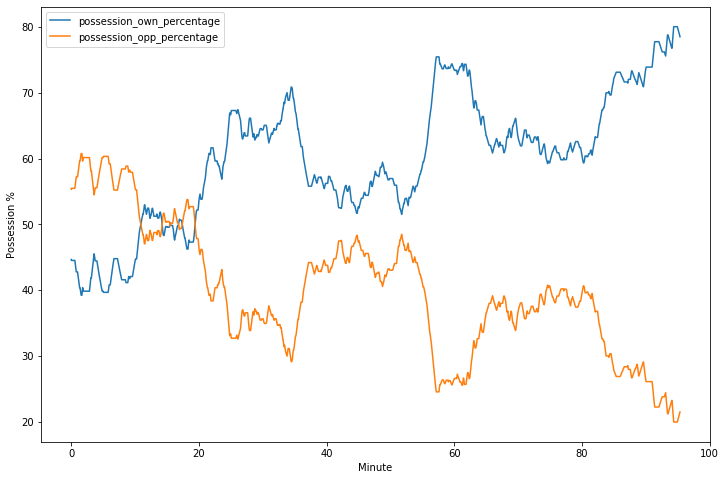

In [304]:
df_for_plot = df_possession_timeline.copy()
df_for_plot.index = df_for_plot.index.seconds / 60

fig, ax = plt.subplots(figsize=(12, 8))
df_for_plot[["possession_own_percentage", "possession_opp_percentage"]].plot(
    ax=ax
)
ax.set(xlabel = "Minute", ylabel="Possession %")
fig.savefig(f"{dataset}_possession_timeline.png")

### Average peaks

In [305]:
from tagging.data import ZONES

In [306]:
df_pos_transition_peak = preprocess_data_for_timeline(path, "positive_transition_peak")
df_possession_peak = preprocess_data_for_timeline(path, "possesion_peak")

df_possession_peak_value = df_possession_peak[ZONES].idxmax(1)
df_pos_transition_peak_value = df_pos_transition_peak[ZONES].idxmax(1)

own_peak_value = pd.concat([df_possession_peak_value, df_pos_transition_peak_value]).sort_index()
own_peak_value = add_game_start_entry(own_peak_value, columns=[0])
own_peak_value = own_peak_value.resample("1min").mean() #.rolling(10, center=True, min_periods=1).mean()

In [307]:
df_neg_transition_peak = preprocess_data_for_timeline(path, "negative_transition_peak")
df_pressing_peak = preprocess_data_for_timeline(path, "pressing_peak")

df_neg_transition_peak_value = df_neg_transition_peak[ZONES].idxmax(1)
df_pressing_peak_value = df_pressing_peak[ZONES].idxmax(1)

opp_peak_value = pd.concat([df_neg_transition_peak_value, df_pressing_peak_value]).sort_index()
opp_peak_value = add_game_start_entry(opp_peak_value, columns=[0])
opp_peak_value = opp_peak_value.resample("1min").mean() #.rolling(10, center=True, min_periods=1).mean()

In [308]:
peak_values = own_peak_value.join(opp_peak_value, lsuffix="_own", rsuffix="_opp")
peak_values = peak_values.rename(columns={"0_own": "own_peak", "0_opp": "opp_peak"})
peak_values = peak_values.fillna(0)

In [309]:
peak_values.iloc[-20:]

,own_peak,opp_peak
01:16:00,7.0,0.0
01:17:00,2.5,5.0
01:18:00,1.0,1.0
01:19:00,2.0,4.0
01:20:00,0.0,0.0
01:21:00,0.0,0.0
01:22:00,2.5,0.0
01:23:00,2.0,5.0
01:24:00,0.0,5.0
01:25:00,5.0,4.0


In [310]:
peak_values_mean = peak_values.rolling(10, center=True, min_periods=1).mean()

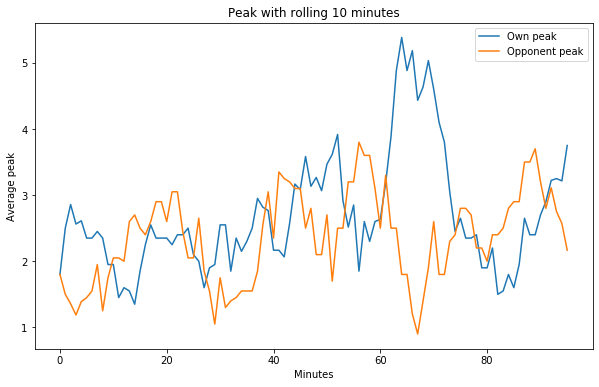

In [311]:
fig, ax = plt.subplots(figsize=(10, 6))

# df_for_plot.index = df_for_plot.index.seconds / 60
ax.plot(peak_values_mean.index.seconds / 60, peak_values_mean["own_peak"], label="Own peak")
ax.plot(peak_values_mean.index.seconds / 60, peak_values_mean["opp_peak"], label="Opponent peak")

ax.set(xlabel="Minutes", ylabel="Average peak", title="Peak with rolling 10 minutes")
ax.legend()
fig.savefig(f"{dataset}_peak_timeline.png")